In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import anndata
import scanpy as sc
import scvi
from cell2location.models import Cell2location, RegressionModel
from cell2location.plt import plot_spatial
from cell2location.utils import select_slide
from cell2location.utils.filtering import filter_genes

/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



In [3]:
mka = sc.read_h5ad("/exports/archive/hg-groep-peters/Healthy_Mouse_Atlas_Claudio/KidneyAtlas/h5ad/atlas_full_raw.h5ad")

In [4]:
zimm = sc.read_h5ad("/exports/archive/hg-groep-peters/Healthy_Mouse_Atlas_Claudio/KidneyAtlas/h5ad/zimmerman_raw.h5ad")

In [5]:
sc.pp.calculate_qc_metrics(zimm, inplace=True)

In [6]:
zimm = zimm[zimm.obs.group.isin(['cmsham', 'agedcontrols', 'contir'])].copy()

In [7]:
zimm.obs['Origin'] = 'Zimmerman22'
zimm.obs['Source'] = 'Cell'

In [8]:
zimm.obs['pct_counts_mt'] = zimm.obs['percent.mt']

In [9]:
mka = mka.concatenate(zimm, join='inner')

/tmp/ipykernel_3681213/1520431125.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  mka = mka.concatenate(zimm, join='inner')
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/anndata/_core/merge.py:1362: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [10]:
mka

AnnData object with n_obs × n_vars = 155738 × 14670
    obs: 'Celltype_Kirita', 'Origin', 'Source', 'Technology', 'Tissue_res', 'Age', 'Genetic_background', 'Gender', 'n_genes', 'Celltype_Park', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'batch', 'Celltype_Susztak', 'Celltype_Wu', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'Celltype_finest', 'Celltype_Dumas', 'Celltype_Janosevic', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'group', 'percent.mt', 'RNA_snn_res.0.3', 'seurat_clusters', 'RNA_snn_res.0.08', 'RNA_snn_res.0.05', 'old.ident', 'all_annot', 'cell_type', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'vst.mean-1', 'vst.variance-1', 'vst.variance.expected-1', 'vst.variance.standardized-1', 'vst.variable-1', 'n_c

In [11]:
humphreys_fibrosis = sc.read_h5ad("/exports/archive/hg-groep-peters/snRNAseq_Cesare_Claudio_Early_Mod_Severe/snRNAseq/humphreys_processed.h5ad")

/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [12]:
humphreys_fibrosis.obs.celltype0421

Unnamed: 0
P5001.AGTCGCATTTTATCCGGAT     PT-Inj
P5001.GATACGTCTGTCCTTAAGA        ICB
P5001.TAGAGAGTATATGGCGGATC        PT
P5001.CTAGTACGTACCAGCGCAG         EC
P5001.CTGGAAGATCGATCATTAC      PT-FR
                               ...  
P5996.TTGAGAGATTACTAGAGAGT    PT-Inj
P5996.GTAGACGGTTCTAGAACTA         PT
P5996.TTCTAAGCTTCCGCGGACCG        PC
P5996.CGTCGAAGTGGACTCATTG         PT
P5996.TGATCTTCTTAAGTAAGAGC    PT-Inj
Name: celltype0421, Length: 306367, dtype: category
Categories (19, object): ['B/T', 'CNT', 'DCT', 'DTL-ATL', ..., 'PT-R', 'Pod', 'TAL', 'Uro']

In [13]:
humphreys_fibrosis = humphreys_fibrosis[humphreys_fibrosis.obs.celltype0421.isin(['PT-AcInj','PT-FR','PT-Inj','PT-R', 'Fib', 'Myofib'])].copy()

/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [14]:
humphreys_fibrosis = humphreys_fibrosis[humphreys_fibrosis.obs['sample'] != 'Health'].copy()

In [15]:
# Filter the anndata object based on the condition in var_names
humphreys_fibrosis = humphreys_fibrosis[:, ~humphreys_fibrosis.var_names.str.contains('intron')].copy()

In [16]:
humphreys_fibrosis.var_names_make_unique()

In [17]:
humphreys_fibrosis.var_names

Index(['Xkr4', 'Gm37381', 'Rp1', 'Rp1-1', 'Sox17', 'Mrpl15', 'Lypla1',
       'Gm37988', 'Tcea1', 'Rgs20',
       ...
       'Gm21693', 'Gm20915', 'Gm28848', 'Gm21865', 'Gm21758', 'Erdr1', 'DHRSX',
       'Vamp7', 'Tmlhe', 'AC149090.1'],
      dtype='object', name='gene_name', length=15866)

In [18]:
humphreys_fibrosis.X = humphreys_fibrosis.layers['raw']

In [19]:
# Step 1: Add the new category
humphreys_fibrosis.obs['celltype0421'] = humphreys_fibrosis.obs['celltype0421'].cat.add_categories(['Podo'])

# Step 2: Assign the new value
humphreys_fibrosis.obs.loc[humphreys_fibrosis.obs['celltype0421'] == 'Pod', 'celltype0421'] = 'Podo'

In [20]:
humphreys_fibrosis.obs["Origin"] = 'Humphreys23'
humphreys_fibrosis.obs["Source"] = 'Nuclei'

In [21]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
humphreys_fibrosis.var["mt"] = humphreys_fibrosis.var_names.str.startswith("mt-")
# ribosomal genes
humphreys_fibrosis.var["ribo"] = humphreys_fibrosis.var_names.str.startswith(("Rps", "Rpl"))

In [22]:
sc.pp.calculate_qc_metrics(
    humphreys_fibrosis, qc_vars=["mt", "ribo"], inplace=True
)

In [23]:
humphreys_fibrosis.var_names

Index(['Xkr4', 'Gm37381', 'Rp1', 'Rp1-1', 'Sox17', 'Mrpl15', 'Lypla1',
       'Gm37988', 'Tcea1', 'Rgs20',
       ...
       'Gm21693', 'Gm20915', 'Gm28848', 'Gm21865', 'Gm21758', 'Erdr1', 'DHRSX',
       'Vamp7', 'Tmlhe', 'AC149090.1'],
      dtype='object', name='gene_name', length=15866)

In [24]:
mka = mka.concatenate([humphreys_fibrosis], join='inner')

/tmp/ipykernel_3681213/4112866633.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  mka = mka.concatenate([humphreys_fibrosis], join='inner')
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/anndata/_core/merge.py:1362: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [25]:
mka

AnnData object with n_obs × n_vars = 251542 × 12179
    obs: 'Celltype_Kirita', 'Origin', 'Source', 'Technology', 'Tissue_res', 'Age', 'Genetic_background', 'Gender', 'n_genes', 'Celltype_Park', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'batch', 'Celltype_Susztak', 'Celltype_Wu', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'Celltype_finest', 'Celltype_Dumas', 'Celltype_Janosevic', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'group', 'percent.mt', 'RNA_snn_res.0.3', 'seurat_clusters', 'RNA_snn_res.0.08', 'RNA_snn_res.0.05', 'old.ident', 'all_annot', 'cell_type', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'celltype0421', 'sample'
    var: 'vst.mean-1-0', 'vst.variance-1-0', 'vst.variance.expected-1-0', 'vst.variance.standar

In [26]:
adata_upd = sc.read_h5ad("/exports/archive/hg-groep-peters/snRNAseq_Cesare_Claudio_Early_Mod_Severe/snRNAseq/latest_models/atlas_lvae_model/avg_posterior_samples.h5ad")

In [27]:
adata_upd.obs['pct_counts_mt']

ACCCACTCATTTGCTT-0-0-0-0        0.114416
TCGCGTTCAGCATGAG-0-0-0-0        0.111111
TTAACTCTCTTAGAGC-0-0-0-0        0.102459
CTGATAGGTCACTTCC-0-0-0-0        0.000000
ACGCAGCCAGCCTATA-0-0-0-0        0.036550
                                  ...   
P5996.TTAATGAGCTCCATAAGTCC-1    0.000000
P5996.GCAATCGCTTATCATGATC-1     0.000000
P5996.AAGACCTTATCAACCAGTAC-1    0.000000
P5996.TTGAGAGATTACTAGAGAGT-1    0.000000
P5996.TGATCTTCTTAAGTAAGAGC-1    0.000000
Name: pct_counts_mt, Length: 245959, dtype: float32

In [28]:
mka = mka[mka.obs_names.isin(adata_upd.obs_names)].copy()

In [29]:
obs_to_keep = mka.obs[['total_counts', 'n_genes_by_counts', 'pct_counts_mt']]

In [30]:
obs_to_keep

,total_counts,n_genes_by_counts,pct_counts_mt
ACCCACTCATTTGCTT-0-0-0-0,890.0,629,0.112360
TCGCGTTCAGCATGAG-0-0-0-0,911.0,594,0.109769
TTAACTCTCTTAGAGC-0-0-0-0,998.0,629,0.100200
CTGATAGGTCACTTCC-0-0-0-0,6335.0,2392,0.015785
ACGCAGCCAGCCTATA-0-0-0-0,2792.0,1390,0.035817
...,...,...,...
P5996.TTAATGAGCTCCATAAGTCC-1,323.0,241,0.000000
P5996.GCAATCGCTTATCATGATC-1,182.0,145,0.000000
P5996.AAGACCTTATCAACCAGTAC-1,84.0,80,0.000000
P5996.TTGAGAGATTACTAGAGAGT-1,3261.0,1651,0.000000


In [31]:
mka.obs = adata_upd.obs

In [32]:
mka.obs[['total_counts', 'n_genes_by_counts', 'pct_counts_mt']] = obs_to_keep

In [33]:
del adata_upd

In [34]:
muto_pkd = sc.read_h5ad("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Muto_PKD_2024/GSE268494_RNA_seurat.h5ad")

In [35]:
muto_pkd = muto_pkd[muto_pkd.obs['disease'].str.contains('pkd')].copy()

In [36]:
muto_pkd = muto_pkd[~muto_pkd.obs['celltype'].isin(['URO', 'FAT', 'Myel'])].copy()

In [37]:
muto_pkd_PT_metadata = pd.read_csv("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Muto_PKD_2024/GSE268494_PKDaggr_GEO_FRPTC_metadata.csv", index_col=0)

In [38]:
# Convert to string dtype
muto_pkd.obs['celltype'] = muto_pkd.obs['celltype'].astype(str)

# Assign new values
common_cells = muto_pkd.obs_names.intersection(muto_pkd_PT_metadata.index)
muto_pkd.obs.loc[common_cells, 'celltype'] = muto_pkd_PT_metadata.loc[common_cells, 'subtype']

# (Optional) Convert back to categorical if desired
muto_pkd.obs['celltype'] = muto_pkd.obs['celltype'].astype('category')

In [39]:
translation_dict = {
    'ATL': 'ATL',
    'Bcell': 'B lymph',
    'CNT': 'CNT',
    'DCT': 'DCT',
    'DTL1': 'DTL',
    'DTL2': 'DTL',
    'ENDO': 'Endo',
    'FIB': 'Fib',
    'FRPTC1': 'PT-FR',
    'FRPTC2': 'PT-FR',
    'FRPTC3': 'PT-FR',
    'ICA': 'ICA',
    'ICB': 'ICB',
    'PC1': 'PC',
    'PC2': 'PC',
    'PEC': 'PEC',
    'PODO': 'Podo',
    'PTS1': 'PTS1',
    'PTS2': 'PTS2',
    'PTS3': 'PTS3',
    'TAL': 'TAL',
    'Tcell': 'T lymph',
    'Trans-PTC': 'Trans-PTC'
}

In [40]:
muto_pkd.obs['celltype'] = muto_pkd.obs['celltype'].replace(translation_dict)

/tmp/ipykernel_3681213/1264890572.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  muto_pkd.obs['celltype'] = muto_pkd.obs['celltype'].replace(translation_dict)


In [41]:
muto_pkd.obs['celltype']

CTACCTCAGCACTAGT-1_4     PTS1
CTTCAATTCGTTATCT-1_4     PTS2
CTCCTCACAGACAAAC-1_4     PTS2
AAGTCTATCCCGCAAA-1_4     PTS3
GGTTGCTCACTAGGTC-1_4     PTS2
                         ... 
TAGCCTCTCCCTCTAA-1_16    PTS3
GTGTAACTCTTGAGGT-1_16    PTS2
CCTTTAGTCCGCACAA-1_16     DTL
GTGTCCAAGGCATGTT-1_16     PEC
TTGTGAGGTTGTGACA-1_16     ICB
Name: celltype, Length: 57832, dtype: category
Categories (19, object): ['ATL', 'B lymph', 'CNT', 'DCT', ..., 'PTS3', 'TAL', 'T lymph', 'Trans-PTC']

In [42]:
muto_pkd.obs['Predicted_Celltype'] = muto_pkd.obs['celltype']

In [43]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
muto_pkd.var["mt"] = muto_pkd.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(
    muto_pkd, qc_vars=["mt"], inplace=True
)

In [44]:
mka = mka.concatenate(muto_pkd, join='inner')

/tmp/ipykernel_3681213/3138094443.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  mka = mka.concatenate(muto_pkd, join='inner')


In [45]:
del mka.var

In [46]:
mka.obs['Origin'] = mka.obs['Origin'].cat.add_categories(['Muto24'])
mka.obs['Origin'] = mka.obs['Origin'].fillna('Muto24')
mka.obs['Source'] = mka.obs['Source'].fillna('Nuclei')

In [48]:
sc.pp.calculate_qc_metrics(mka, inplace=True)

/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


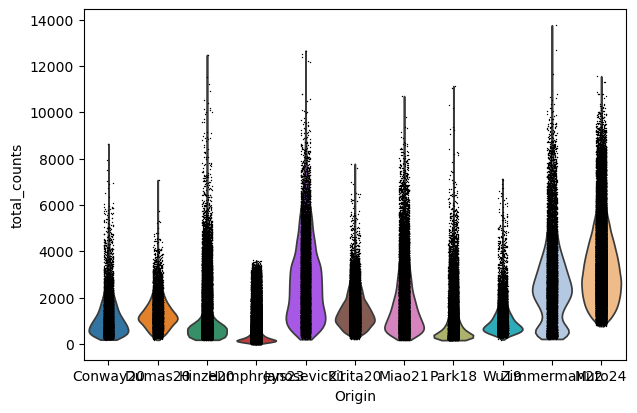

In [49]:
sc.pl.violin(mka, 'total_counts', groupby='Origin')

In [50]:
mka.write_h5ad("/exports/archive/hg-groep-peters/snRNAseq_Cesare_Claudio_Early_Mod_Severe/snRNAseq/mka_extended_pkd_innerjoin.h5ad")

In [49]:
mka = sc.read_h5ad("/exports/archive/hg-groep-peters/snRNAseq_Cesare_Claudio_Early_Mod_Severe/snRNAseq/mka_extended_pkd_innerjoin.h5ad")

## scVI / scANVI

In [50]:
scvi.model.SCVI.setup_anndata(mka, batch_key="Origin", continuous_covariate_keys=['pct_counts_mt'], 
                      categorical_covariate_keys=['Source'])

In [56]:
# vae = scvi.model.SCVI(mka, n_layers=2, n_latent=26, gene_likelihood='nb', dropout_rate=0.09672091885923559)

In [130]:
# for reference mapping
# vae = scvi.model.SCVI(mka, 
#                       n_layers=2, 
#                       use_layer_norm="both",
#                       use_batch_norm="none",
#                       encode_covariates=True,
#                       n_latent=26, 
#                       gene_likelihood="nb", 
#                       dropout_rate=0.09672091885923559)

In [51]:
vae = scvi.model.SCVI(mka, 
                      n_layers=2, 
                      use_layer_norm="both",
                      use_batch_norm="none",
                      encode_covariates=True,
                      n_latent=26, 
                      gene_likelihood="nb", 
                      dropout_rate=0.2)

In [52]:
vae.train()

/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /exports/archive/hg-funcgenom-research/cnovellarause ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /exports/archive/hg-funcgenom-research/cnovellarause ..

Training:   0%|          | 0/26 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=26` reached.


In [ ]:
#vae.train(plan_kwargs={"lr":0.0013153399994028092})

In [53]:
mka.obsm["X_scVI"] = vae.get_latent_representation()

In [54]:
sc.pp.neighbors(mka, use_rep="X_scVI")
# sc.tl.leiden(adata_upd)
sc.tl.umap(mka)

In [56]:
sc.pl.umap(
    mka,
    color="Origin",
    frameon=False,
    show=False,
    save='MKA_extended_byOrigin.pdf'
)

/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Origin'}, xlabel='UMAP1', ylabel='UMAP2'>

In [57]:
sc.pl.umap(
    mka,
    color="Predicted_Celltype",
    frameon=False,
    show=False,
    save='MKA_extended_byCelltype.pdf'
)

/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Predicted_Celltype'}, xlabel='UMAP1', ylabel='UMAP2'>

In [58]:
vae.save("/exports/humgen/cnovellarausell/SevtapSpatial/Models/SCVI_zimmerman_humphreys_muto", save_anndata=True, overwrite=True)

In [ ]:
mka.obs.Predicted_Celltype.cat.add_categories(new_categories='Unknown', inplace=True)

In [ ]:
mka.obs.loc[mka.obs.Origin.isin(['Conway20', 'Hinze20']), 'Predicted_Celltype'] = 'Unknown'

In [21]:
mka.obs.groupby('Origin')['Predicted_Celltype'].value_counts()

/tmp/ipykernel_280044/184395419.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mka.obs.groupby('Origin')['Predicted_Celltype'].value_counts()


Origin    Predicted_Celltype         
Conway20  PTS2                           3142
          PTS3                            857
          PTS1                            558
          TAL                             348
          Endo                            155
                                         ... 
Muto24    PTS3T2                            0
          Per                               0
          Spp1+ Resident Macrophages        0
          T1 B lymph                        0
          T3/Follicular B lymph             0
Name: count, Length: 550, dtype: int64

In [59]:
mapping = {
    'Lyc6 high Macrophages': 'Macro',
    'Macrophages': 'Macro',
    'Lyc6 low Macrophages': 'Macro',
    'Mrc1+ Resident Macrophages': 'Macro',
    'Resident Macrophages': 'Macro',
    'Spp1+ Resident Macrophages ': 'Macro',
    'Monocyte/DC': 'DC',
    'Dendritic': 'DC',
    'B1 B lymph': 'B lymph',
    'CD4+ T lymph': 'T lymph',
    'CD4+ T regs': 'T regs',
    'CD4+ Th17': 'Th17',
    'Gzma low NK': 'NK',
    'Gzma+ CD8+ T lymph': 'T lymph',
    'Gzma+ NK': 'NK',
    'Memory B lymph': 'B lymph',
    'NKT1': 'NK',
    'T1 B lymph': 'B lymph',
    'T3/Follicular B lymph': 'B lymph',
    'Th17': 'T lymph',
'Mesanglial cells': 'MC',
'IC': 'IC',
    'FR-PT + Immune': 'FR-PT + Immune',
    'Immune': 'Immune',
}

mka.obs["Predicted_Celltype_lowres"] = mka.obs["Predicted_Celltype"].replace(mapping)

/tmp/ipykernel_3831504/1678811046.py:28: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  mka.obs["Predicted_Celltype_lowres"] = mka.obs["Predicted_Celltype"].replace(mapping)


In [60]:
mka.obs["Predicted_Celltype_lowres"]

ACCCACTCATTTGCTT-0-0-0-0-0    Endo
TCGCGTTCAGCATGAG-0-0-0-0-0     TAL
TTAACTCTCTTAGAGC-0-0-0-0-0      PC
CTGATAGGTCACTTCC-0-0-0-0-0    PTS2
ACGCAGCCAGCCTATA-0-0-0-0-0    PTS2
                              ... 
TAGCCTCTCCCTCTAA-1_16-1       PTS3
GTGTAACTCTTGAGGT-1_16-1       PTS2
CCTTTAGTCCGCACAA-1_16-1        DTL
GTGTCCAAGGCATGTT-1_16-1        PEC
TTGTGAGGTTGTGACA-1_16-1        ICB
Name: Predicted_Celltype_lowres, Length: 303791, dtype: category
Categories (37, object): ['ATL', 'B lymph', 'T regs', 'Th17', ..., 'Podo', 'T lymph', 'TAL', 'Trans-PTC']

In [61]:
SCANVI_LABELS_KEY = "labels_scanvi"

mka.obs[SCANVI_LABELS_KEY] = mka.obs['Predicted_Celltype_lowres'].values

In [62]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=mka,
    labels_key=SCANVI_LABELS_KEY,
    unlabeled_category='Unknown'
)

In [63]:
lvae.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /exports/archive/hg-funcgenom-research/cnovellarause ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /exports/archive/hg-funcgenom-research/cnovellarause ..

Training:   0%|          | 0/20 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [64]:
lvae.save("/exports/humgen/cnovellarausell/SevtapSpatial/Models/SCANVI_zimmerman_humphreys_muto_lowres", save_anndata=True, overwrite=True)

In [2]:
lvae = scvi.model.SCANVI.load("/exports/humgen/cnovellarausell/SevtapSpatial/Models/SCANVI_zimmerman_humphreys_muto_lowres")

INFO     File /exports/humgen/cnovellarausell/SevtapSpatial/Models/SCANVI_zimmerman_humphreys_muto_lowres/model.pt 
         already downloaded                                                                                        


/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /exports/archive/hg-funcgenom-research/cnovellarause ...
  rank_zero_warn(


In [3]:
mka = lvae.adata.copy()

In [65]:
mka.obsm["X_scANVI"] = lvae.get_latent_representation()
sc.pp.neighbors(mka, use_rep="X_scANVI")
sc.tl.umap(mka)

In [66]:
sc.pl.umap(
    mka,
    color=["Predicted_Celltype_lowres"],
    frameon=False,
    show=False,
    size=2,
    save='MKA_extended_scANVI_byCelltype.pdf'
)

/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Predicted_Celltype_lowres'}, xlabel='UMAP1', ylabel='UMAP2'>

In [67]:
sc.pl.umap(
    mka,
    color=["Origin"],
    frameon=False,
    show=False,
    size=2,
    save='MKA_extended_scANVI_byOrigin.pdf'
)

/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Origin'}, xlabel='UMAP1', ylabel='UMAP2'>

In [72]:
mka.var_names

Index(['Serpinb8', 'Aox1', 'Cnnm3', 'Lman2l', 'Ankrd39', 'Usf1', 'Rrp15',
       'Ddx18', 'Disp1', 'Elf3',
       ...
       'Chic1', 'Msn', '2610002M06Rik', 'Ftx', 'Kantr', 'Gm14827', 'Gm15232',
       'Jpx', '2010308F09Rik', 'Uty'],
      dtype='object', length=12156)

In [ ]:
sc.pl.umap(
    mka,
    color=["Disp1"],
    frameon=False,
    show=False,
    size=2,
)

In [68]:
latent = lvae.get_latent_representation(mka)
np.savetxt("/exports/humgen/cnovellarausell/SevtapSpatial/Models/SCANVI_zimmerman_humphreys_muto_lowres/MKA_extended_scANVI_latent_space.csv", latent, delimiter=",")
pd.DataFrame(mka.obs['Predicted_Celltype_lowres']).to_csv("/exports/humgen/cnovellarausell/SevtapSpatial/Models/SCANVI_zimmerman_humphreys_muto_lowres/cell_types.csv")

In [64]:
mka.obs.Source

ACCCACTCATTTGCTT-0-0-0-0-0    Nuclei
TCGCGTTCAGCATGAG-0-0-0-0-0    Nuclei
TTAACTCTCTTAGAGC-0-0-0-0-0    Nuclei
CTGATAGGTCACTTCC-0-0-0-0-0    Nuclei
ACGCAGCCAGCCTATA-0-0-0-0-0    Nuclei
                               ...  
TAGCCTCTCCCTCTAA-1_16-1       Nuclei
GTGTAACTCTTGAGGT-1_16-1       Nuclei
CCTTTAGTCCGCACAA-1_16-1       Nuclei
GTGTCCAAGGCATGTT-1_16-1       Nuclei
TTGTGAGGTTGTGACA-1_16-1       Nuclei
Name: Source, Length: 303791, dtype: category
Categories (2, object): ['Cell', 'Nuclei']

In [4]:
# Assuming `mka` is your AnnData object
annotations = pd.DataFrame(
    {
        'Predicted_Celltype_lowres': mka.obs['Predicted_Celltype_lowres'],
        'Batch': mka.obs['Origin']  # Add the 'Origin' column
    },
    index=mka.obs_names
)

# Set the index name to 'barcode'
annotations.index.name = 'barcode'

# Save to CSV
annotations.to_csv(
    '/exports/humgen/cnovellarausell/SevtapSpatial/cytospace/MKA_extended_annotations_lowres_withBatch.csv',
    sep=','
)

In [5]:
# Assuming `mka` is your AnnData object
annotations = pd.DataFrame(
    {
        'Predicted_Celltype_highres': mka.obs['Predicted_Celltype'],
        'Batch': mka.obs['Origin']  # Add the 'Origin' column
    },
    index=mka.obs_names
)

# Set the index name to 'barcode'
annotations.index.name = 'barcode'

# Save to CSV
annotations.to_csv(
    '/exports/humgen/cnovellarausell/SevtapSpatial/cytospace/MKA_extended_annotations_highres_withBatch.csv',
    sep=','
)

In [69]:
annotations = pd.DataFrame(mka.obs['Predicted_Celltype'], columns=['Predicted_Celltype'], index=mka.obs_names)
annotations.index.name = 'barcode'
annotations.to_csv('/exports/humgen/cnovellarausell/SevtapSpatial/cytospace/MKA_extended_annotations_highres.csv', sep=',')

In [70]:
annotations = pd.DataFrame(mka.obs['Predicted_Celltype_lowres'], columns=['Predicted_Celltype_lowres'], index=mka.obs_names)
annotations.index.name = 'barcode'
annotations.to_csv('/exports/humgen/cnovellarausell/SevtapSpatial/cytospace/MKA_extended_annotations_lowres.csv', sep=',')

In [25]:
adata_upd = sc.read_h5ad("/exports/archive/hg-groep-peters/Healthy_Mouse_Atlas_Claudio/KidneyAtlas/h5ad/atlas_full_SCVI_SCANVI_Zimmerman.h5ad")

In [30]:
adata_upd

AnnData object with n_obs × n_vars = 245959 × 12179
    obs: 'Origin', 'Source', 'Technology', 'Tissue_res', 'Age', 'Genetic_background', 'Gender', 'Predicted_Celltype', 'Predicted_Celltype_lowres', 'sample', 'pct_counts_mt', '_scvi_batch', '_scvi_labels'
    uns: 'Origin_colors', 'Predicted_Celltype_lowres_colors', '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'umap'
    obsm: 'X_scANVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    obsp: 'connectivities', 'distances'

In [33]:
mka = mka[mka.obs_names.isin(adata_upd.obs_names.to_list())].copy()

In [37]:
mka.raw

In [3]:
adata_upd = adata_upd.raw.to_adata()

In [5]:
humphreys_fibrosis = sc.read_h5ad("/exports/humgen/cnovellarausell/snRNAseq/humphreys_processed.h5ad")

/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
humphreys_fibrosis = humphreys_fibrosis[~humphreys_fibrosis.obs.celltype0421.isin(['EC', 'Mφ', 'B/T', 'Uro'])].copy()

/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
humphreys_fibrosis.obs.celltype0421.value_counts()

celltype0421
PT          76084
PT-Inj      42204
Fib         26032
TAL         25266
PT-FR       16046
PC          11971
DCT         10799
ICB          7911
Myofib       7639
CNT          7305
PT-R         6851
ICA          6442
DTL-ATL      5541
Pod          4038
PT-AcInj     2705
Name: count, dtype: int64

In [8]:
humphreys_fibrosis.X = humphreys_fibrosis.layers['raw']

In [9]:
# Step 1: Add the new category
humphreys_fibrosis.obs['celltype0421'] = humphreys_fibrosis.obs['celltype0421'].cat.add_categories(['Podo'])

# Step 2: Assign the new value
humphreys_fibrosis.obs.loc[humphreys_fibrosis.obs['celltype0421'] == 'Pod', 'celltype0421'] = 'Podo'

In [10]:
adata_upd.obs['Predicted_Celltype_lowres'] = adata_upd.obs.Predicted_Celltype_lowres.cat.add_categories(['TAL'])
adata_upd.obs.loc[adata_upd.obs.Predicted_Celltype_lowres == 'MTAL', 'Predicted_Celltype_lowres'] = 'TAL'
adata_upd.obs.loc[adata_upd.obs.Predicted_Celltype_lowres == 'CTAL', 'Predicted_Celltype_lowres'] = 'TAL'

In [11]:
adata_upd.obs.Predicted_Celltype_lowres = adata_upd.obs.Predicted_Celltype_lowres.cat.remove_unused_categories()
humphreys_fibrosis.obs.celltype0421 = humphreys_fibrosis.obs.celltype0421.cat.remove_unused_categories()

In [12]:
humphreys_fibrosis.obs.celltype0421.value_counts(), adata_upd.obs.Predicted_Celltype_lowres.value_counts()

(celltype0421
 PT          76084
 PT-Inj      42204
 Fib         26032
 TAL         25266
 PT-FR       16046
 PC          11971
 DCT         10799
 ICB          7911
 Myofib       7639
 CNT          7305
 PT-R         6851
 ICA          6442
 DTL-ATL      5541
 Podo         4038
 PT-AcInj     2705
 Name: count, dtype: int64,
 Predicted_Celltype_lowres
 PTS2         32717
 PTS1         18024
 PTS3         17613
 DCT          16381
 Endo         11702
 TAL           7440
 Macro         6747
 T lymph       5251
 PC            4975
 PTS3T2        4478
 CNT           3903
 Glom-Endo     3547
 B lymph       2800
 ICB           2447
 DTL-ATL       1932
 ATL           1610
 LOH           1552
 ICA           1488
 Fib           1070
 NK             847
 DCT-CNT        810
 Podo           558
 DC             553
 Neutro         529
 DTL            372
 T regs         302
 Per            154
 Th17           131
 PEC            117
 CD-Trans        59
 MD              46
 Name: count, dtype: int64

In [17]:
adata_upd.raw.X

<150155x14670 sparse matrix of type '<class 'numpy.float32'>'
	with 143229868 stored elements in Compressed Sparse Row format>

In [82]:
humphreys_fibrosis.obs["Origin"] = 'Humphreys23'
humphreys_fibrosis.obs["Source"] = 'Nuclei'

In [83]:
humphreys_fibrosis.var['mt'] = humphreys_fibrosis.var_names.str.startswith('mt-')
humphreys_fibrosis.var['ribo'] = humphreys_fibrosis.var_names.str.startswith(('Rps', 'Rpl'))
humphreys_fibrosis.var['hb'] = humphreys_fibrosis.var_names.str.contains(("^Hb.*-"))
sc.pp.calculate_qc_metrics(humphreys_fibrosis, qc_vars=['mt', 'ribo', 'hb'], percent_top=None,inplace=True)

In [84]:
humphreys_fibrosis.var_names_make_unique()         # Check for duplicates in adata_upd

In [85]:
humphreys_fibrosis = humphreys_fibrosis[humphreys_fibrosis.obs['sample'] != 'Health'].copy()

In [86]:
adata_upd = adata_upd.concatenate([humphreys_fibrosis])

/tmp/ipykernel_1587041/724076699.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_upd = adata_upd.concatenate([humphreys_fibrosis])
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/anndata/_core/merge.py:1357: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [87]:
adata_upd.obs.celltype0421 = adata_upd.obs.celltype0421.astype(str)
adata_upd.obs.celltype0421.fillna('', inplace=True)
adata_upd.obs.Predicted_Celltype_lowres = adata_upd.obs.Predicted_Celltype_lowres.astype(str)
adata_upd.obs.Predicted_Celltype = adata_upd.obs.Predicted_Celltype.astype(str)
adata_upd.obs.Predicted_Celltype_lowres.fillna('', inplace=True)
adata_upd.obs.Predicted_Celltype.fillna('', inplace=True)

/tmp/ipykernel_1587041/3179380017.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata_upd.obs.celltype0421.fillna('', inplace=True)
/tmp/ipykernel_1587041/3179380017.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

In [88]:
adata_upd.obs["Predicted_Celltype"] = adata_upd.obs[["Predicted_Celltype", "celltype0421"]].agg(''.join, axis=1)
adata_upd.obs["Predicted_Celltype"] = adata_upd.obs["Predicted_Celltype"].str.replace('nan', '')

In [89]:
adata_upd.obs.Predicted_Celltype = adata_upd.obs.Predicted_Celltype.astype('category')

In [90]:
adata_upd.obs.loc[adata_upd.obs.Predicted_Celltype == 'MTAL', 'Predicted_Celltype'] = 'TAL'
adata_upd.obs.loc[adata_upd.obs.Predicted_Celltype == 'CTAL', 'Predicted_Celltype'] = 'TAL'

In [91]:
adata_upd.obs["Predicted_Celltype_lowres"] = adata_upd.obs[["Predicted_Celltype_lowres", "celltype0421"]].agg(''.join, axis=1)
adata_upd.obs["Predicted_Celltype_lowres"] = adata_upd.obs["Predicted_Celltype_lowres"].str.replace('nan', '')

In [92]:
adata_upd.obs.Predicted_Celltype_lowres = adata_upd.obs.Predicted_Celltype_lowres.astype('category')

In [93]:
adata_upd

AnnData object with n_obs × n_vars = 355876 × 12179
    obs: 'Celltype_Kirita', 'Origin', 'Source', 'Technology', 'Tissue_res', 'Age', 'Genetic_background', 'Gender', 'n_genes', 'Celltype_Park', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'batch', 'Celltype_Susztak', 'Celltype_Wu', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'Celltype_finest', 'Celltype_Dumas', 'Celltype_Janosevic', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'group', 'percent.mt', 'RNA_snn_res.0.3', 'seurat_clusters', 'RNA_snn_res.0.08', 'RNA_snn_res.0.05', 'old.ident', 'all_annot', 'cell_type', 'Predicted_Celltype_all_2', 'Predicted_Celltype', 'Predicted_Celltype_lowres', '_scvi_batch', '_scvi_labels', 'leiden', 'celltype0421', 'sample'
    var: 'mt', 'ribo', 'hb', 'vst.mean-1-0', 'vst.variance-1-0', 'vst.variance.expected-1-0', 'vst

In [94]:
obstokeep = ['Origin', 'Source', 'Technology', 'Tissue_res', 'Age', 'Genetic_background', 'Gender', 'Predicted_Celltype', 'Predicted_Celltype_lowres', 'sample', 'pct_counts_mt']

In [95]:
adata_upd.obs = adata_upd.obs.filter(obstokeep)

In [96]:
del adata_upd.var

In [97]:
adata_upd

AnnData object with n_obs × n_vars = 355876 × 12179
    obs: 'Origin', 'Source', 'Technology', 'Tissue_res', 'Age', 'Genetic_background', 'Gender', 'Predicted_Celltype', 'Predicted_Celltype_lowres', 'sample', 'pct_counts_mt'

In [98]:
mapping = {
    'Macrophages': 'Macro',
    'Resident Macrophages': 'Macro',
    'Monocyte/DC': 'DC',
    'Dendritic': 'DC',
'Mesanglial cells': 'MC'}
adata_upd.obs["Predicted_Celltype"] = adata_upd.obs["Predicted_Celltype"].replace(mapping)

In [108]:
humphreys_fibrosis.obs['celltype0421'].value_counts().to_frame()

,count
celltype0421,
PT,44613
PT-Inj,40297
Fib,22868
TAL,21652
PT-FR,16025
PC,10006
DCT,8712
Myofib,7476
PT-R,6592


In [109]:
to_remove = adata_upd.obs.loc[(adata_upd.obs.Origin == 'Humphreys23') & (~adata_upd.obs.Predicted_Celltype.isin(['PT-AcInj','PT-FR','PT-Inj','PT-R', 'Fib', 'Myofib']))].index

In [110]:
adata_upd = adata_upd[~adata_upd.obs_names.isin(to_remove)].copy()

In [111]:
adata_upd

AnnData object with n_obs × n_vars = 245959 × 12179
    obs: 'Origin', 'Source', 'Technology', 'Tissue_res', 'Age', 'Genetic_background', 'Gender', 'Predicted_Celltype', 'Predicted_Celltype_lowres', 'sample', 'pct_counts_mt'

In [118]:
adata_upd.obs['Predicted_Celltype_lowres'] = adata_upd.obs['Predicted_Celltype_lowres'].replace({'T regs': 'T lymph', 'Th17': 'T lymph'})

/tmp/ipykernel_1587041/3453265868.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata_upd.obs['Predicted_Celltype_lowres'] = adata_upd.obs['Predicted_Celltype_lowres'].replace({'T regs': 'T lymph', 'Th17': 'T lymph'})


In [119]:
adata_upd.obs['Predicted_Celltype_lowres'].value_counts()

Predicted_Celltype_lowres
PT-Inj       40297
PTS2         32717
Fib          23938
PTS1         18024
PTS3         17613
DCT          16381
PT-FR        16025
Endo         11702
Myofib        7476
TAL           7440
Macro         6747
PT-R          6592
T lymph       5684
PC            4975
PTS3T2        4478
CNT           3903
Glom-Endo     3547
B lymph       2800
PT-AcInj      2546
ICB           2447
DTL-ATL       1932
ATL           1610
LOH           1552
ICA           1488
NK             847
DCT-CNT        810
Podo           558
DC             553
Neutro         529
DTL            372
Per            154
PEC            117
CD-Trans        59
MD              46
Name: count, dtype: int64

In [120]:
adata_upd.write_h5ad("/exports/archive/hg-groep-peters/Healthy_Mouse_Atlas_Claudio/KidneyAtlas/h5ad/atlas_updated_zimm_humphreys_raw.h5ad")

In [3]:
adata_upd = sc.read_h5ad("/exports/archive/hg-groep-peters/Healthy_Mouse_Atlas_Claudio/KidneyAtlas/h5ad/atlas_updated_zimm_humphreys_raw.h5ad")

In [4]:
adata_upd

AnnData object with n_obs × n_vars = 245959 × 12179
    obs: 'Origin', 'Source', 'Technology', 'Tissue_res', 'Age', 'Genetic_background', 'Gender', 'Predicted_Celltype', 'Predicted_Celltype_lowres', 'sample', 'pct_counts_mt'

In [7]:
annotations = pd.DataFrame(
    adata_upd.obs['Predicted_Celltype'], 
    columns=['Predicted_Celltype'], 
    index=adata_upd.obs_names
)
annotations.index.name = 'barcode'

# Extract batch information (assuming it's in .obs['Origin'])
annotations['Batch'] = adata_upd.obs['Origin']

# Save the DataFrame to a CSV file
annotations.to_csv('/exports/humgen/cnovellarausell/SevtapSpatial/cytospace/atlas_annotations_withZimmermanHumphreys_highres.csv', sep=',')

In [6]:
annotations

,Predicted_Celltype
barcode,
ACCCACTCATTTGCTT-0-0-0-0,Endo
TCGCGTTCAGCATGAG-0-0-0-0,TAL
TTAACTCTCTTAGAGC-0-0-0-0,PC
CTGATAGGTCACTTCC-0-0-0-0,PTS2
ACGCAGCCAGCCTATA-0-0-0-0,PTS2
...,...
P5996.TTAATGAGCTCCATAAGTCC-1,PT-Inj
P5996.GCAATCGCTTATCATGATC-1,PT-R
P5996.AAGACCTTATCAACCAGTAC-1,Fib


In [8]:
annotations = pd.DataFrame(adata_upd.obs['Predicted_Celltype_lowres'], columns=['Predicted_Celltype_lowres'], index=adata_upd.obs_names)
annotations.index.name = 'barcode'
annotations['Batch'] = adata_upd.obs['Origin']
annotations.to_csv('/exports/humgen/cnovellarausell/SevtapSpatial/cytospace/atlas_annotations_withZimmermanHumphreys_lowres.csv', sep=',')

In [123]:
adata_upd = adata_upd.T

In [1]:
adata_upd

NameError: name 'adata_upd' is not defined

In [124]:
counts = pd.DataFrame(data=adata_upd.X.toarray(), index=adata_upd.obs_names, columns=adata_upd.var_names)

In [126]:
counts.to_csv('/exports/humgen/cnovellarausell/SevtapSpatial/cytospace/atlas_raw_counts_full_withZimmermanHumphreys.csv')


KeyboardInterrupt



In [133]:
adata_upd.raw = adata_upd  # keep full dimension safe
# sc.pp.highly_variable_genes(
#     adata_upd,
#     flavor="seurat_v3",
#     n_top_genes=3000,
#     batch_key="Origin",
#     subset=True
# )

In [134]:
adata_upd

AnnData object with n_obs × n_vars = 245959 × 12179
    obs: 'Origin', 'Source', 'Technology', 'Tissue_res', 'Age', 'Genetic_background', 'Gender', 'Predicted_Celltype', 'Predicted_Celltype_lowres', 'sample', 'pct_counts_mt'

In [135]:
sc.pp.filter_cells(adata_upd, min_counts=1)

In [136]:
adata_upd

AnnData object with n_obs × n_vars = 245959 × 12179
    obs: 'Origin', 'Source', 'Technology', 'Tissue_res', 'Age', 'Genetic_background', 'Gender', 'Predicted_Celltype', 'Predicted_Celltype_lowres', 'sample', 'pct_counts_mt', 'n_counts'

In [137]:
scvi.model.SCVI.setup_anndata(adata_upd, batch_key="Origin", continuous_covariate_keys=['pct_counts_mt'], 
                      categorical_covariate_keys=['Source'])

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



In [138]:
vae = scvi.model.SCVI(adata_upd, n_layers=2, n_latent=26, gene_likelihood="nb", dropout_rate=0.09672091885923559)

In [139]:
vae.train(plan_kwargs={"lr":0.0013153399994028092})

/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /exports/archive/hg-funcgenom-research/cnovellarause ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /exports/archive/hg-funcgenom-research/cnovellarause ...
  r

Epoch 1/33:   0%|          | 0/33 [00:00<?, ?it/s]

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



Epoch 3/33:   6%|▌         | 2/33 [21:21<5:34:24, 647.25s/it, v_num=1, train_loss_step=2.26e+3, train_loss_epoch=2.25e+3]

/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


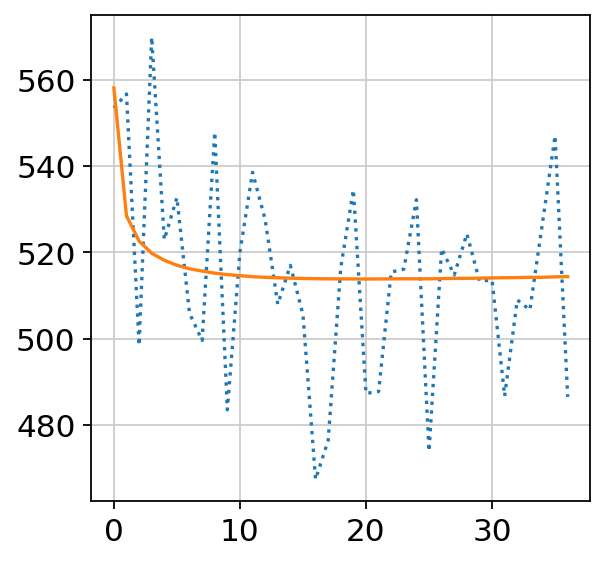

In [138]:
plt.plot(vae.history['train_loss_step']['train_loss_step'], label='train_step', ls=":");
plt.plot(vae.history['train_loss_epoch']['train_loss_epoch'], label='train_epoch');

In [139]:
adata_upd.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata_upd, use_rep="X_scVI")
# sc.tl.leiden(adata_upd)
sc.tl.umap(adata_upd)

In [142]:
adata_upd.obs.Predicted_Celltype_lowres.cat.add_categories(new_categories='Unknown', inplace=True)

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [144]:
adata_upd.obs.loc[adata_upd.obs.Origin.isin(['Conway20', 'Hinze20']), 'Predicted_Celltype_lowres'] = 'Unknown'

In [12]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata_upd,
    labels_key="Predicted_Celltype_lowres",
    unlabeled_category='Unknown'
)

NameError: name 'vae' is not defined

In [146]:
lvae.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [25:46<00:00, 77.01s/it, loss=639, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [25:46<00:00, 77.33s/it, loss=639, v_num=1]


In [147]:
adata_upd.obsm["X_scANVI"] = lvae.get_latent_representation(adata_upd)
sc.pp.neighbors(adata_upd, use_rep="X_scANVI")
#sc.tl.leiden(adata)
sc.tl.umap(adata_upd)

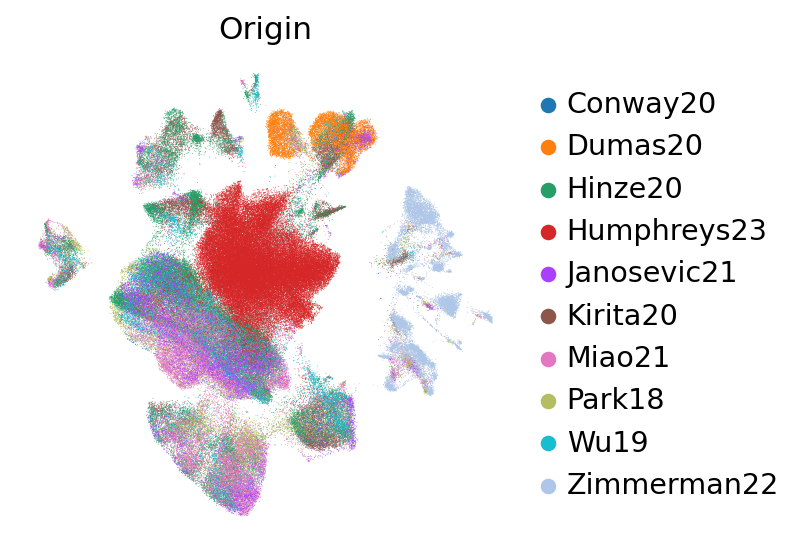

In [148]:
sc.pl.umap(
    adata_upd,
    color="Origin",
    frameon=False,
    show=False
)
plt.savefig("umap_atlas_zimmerman_humphreys_scanvi.svg")

In [152]:
adata_upd.obs["Predicted_Celltype_lowres"] = adata_upd.obs["Predicted_Celltype"].replace(mapping)

In [153]:
mapping = {
    'Lyc6 high Macrophages': 'Macro',
    'Macrophages': 'Macro',
    'Lyc6 low Macrophages': 'Macro',
    'Mrc1+ Resident Macrophages': 'Macro',
    'Resident Macrophages': 'Macro',
    'Spp1+ Resident Macrophages ': 'Macro',
    'Monocyte/DC': 'DC',
    'Dendritic': 'DC',
    'B1 B lymph': 'B lymph',
    'CD4+ T lymph': 'T lymph',
    'CD4+ T regs': 'T regs',
    'CD4+ Th17': 'Th17',
    'Gzma low NK': 'NK',
    'Gzma+ CD8+ T lymph': 'T lymph',
    'Gzma+ NK': 'NK',
    'Memory B lymph': 'B lymph',
    'NKT1': 'NK',
    'T1 B lymph': 'B lymph',
    'T3/Follicular B lymph': 'B lymph',
'Mesanglial cells': 'MC'}

adata_upd.obs["Predicted_Celltype_lowres"] = adata_upd.obs["Predicted_Celltype"].replace(mapping)

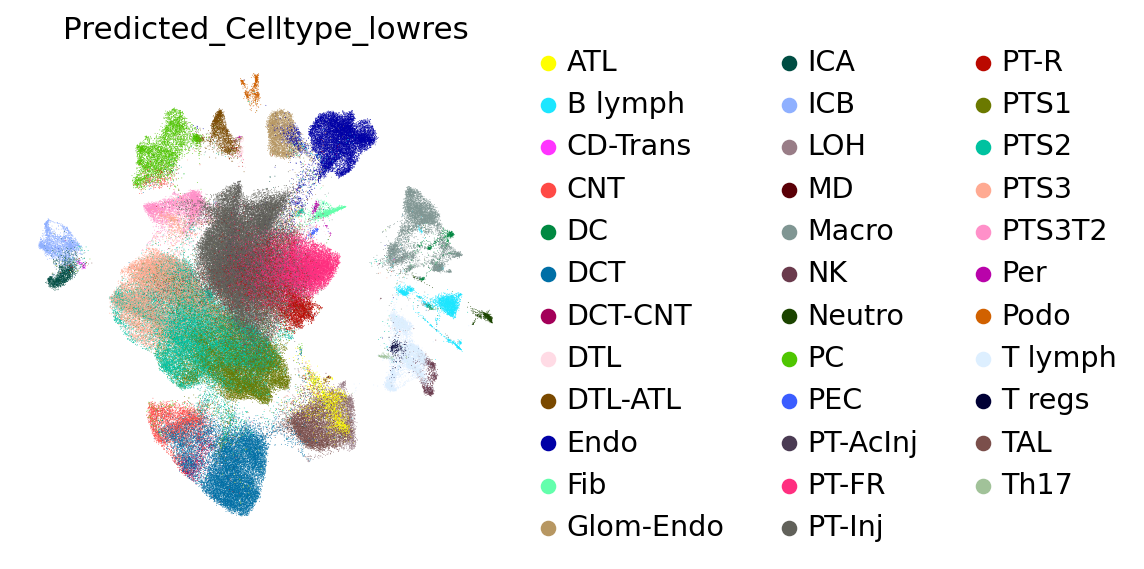

In [154]:
sc.pl.umap(
    adata_upd,
    color="Predicted_Celltype_lowres",
    frameon=False,
    show=False
)
plt.savefig("umap_atlas_zimmerman_humphreys_CT_scanvi.svg")

In [155]:
adata_upd.write_h5ad("/exports/humgen/cnovellarausell/KidneyAtlas/h5ad/atlas_full_SCVI_SCANVI_Zimmerman_Humphreys.h5ad")

In [156]:
lvae.save("/exports/humgen/cnovellarausell/KidneyAtlas/SCANVI_zimmerman_humphreys", save_anndata=True, overwrite=True)

In [3]:
lvae = scvi.model.SCANVI.load("/exports/humgen/cnovellarausell/KidneyAtlas/SCANVI_zimmerman_humphreys")

INFO     File /exports/humgen/cnovellarausell/KidneyAtlas/SCANVI_zimmerman_humphreys/model.pt already downloaded   
